## Social Distance Monitoring and Multiple People Localization with low resolution IR data

This notebook is designed to facilitate the use of low-resolution infrared data from www.kaggle.com/andreyperov/lowresir-detect-and-distance for non-invasive social monitoring and the localization of multiple individuals through deep learning techniques. The dataset was developed as part of a research project at Leuphana University of Lüneburg, and is discussed in the conference paper titled "Privacy-Preserving Localization and Social Distance Monitoring with Low-Resolution Thermal Imaging and Deep Learning," authored by Andrei Perov and Jens Heger.

The dataset is split into:

- Social Distance Violation Detection: 98,000 training frames and 25,500 testing frames are categorized into four classes based on the number of observed distance rule violations (less than 1.5 meters between two given individuals).
- People Localization: 42,800 frames for training and 11,100 for testing. Each row contains the list of coordinates representing the location of the heads of the people on the frame.
Data are stored in CSV format with each row corresponding to temperature readings for each frame. with 10% of the data presenting challenging scenarios for traditional methods.

**Full code base with many different models and additional functions you can find in the github repository of the paper**

**Please reference the repository in your codebase and include a citation in your written documentation.**

First lets import all the neccessary libraries

In [66]:
import torch
import os
import datetime
import torch.nn as nn
import torch.nn.functional as F 
import torchvision.transforms.functional as TF
import torch.optim as optim
import pickle 
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler, Dataset, Subset
import random
from collections import defaultdict
import ast
import torch.optim as optim
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import label_binarize

### 1. Social Distance Monitoring

Download the datasets for social distance rule violation counting. The dataset exhi

In [2]:
df_test = pd.read_csv('distance_test_11_06.csv')
df_train = pd.read_csv('distance_train_09_06.csv')

In [3]:
import warnings
warnings.filterwarnings('ignore')

To process the corresponding data for subsequent modelling we need following functions:

In [ ]:
def format_data_distancing(df, interpolate=True):
    pixel = df.columns[0:64]
    sessions_unique = df['session'].unique()
    num_sessions = len(sessions_unique)

    # Preallocate a list of lists
    session_arrays = [None] * num_sessions
    
    for i, session_label in enumerate(sessions_unique):
        df_temp = df[df['session'] == session_label]
        # Preallocate list for tuples (image, label) for each image
        pics_tuples = []

        for idx, row in df_temp.iterrows():
            # Extract pixel values and check if it can be reshaped to 8x8
            pic = pd.to_numeric(row[pixel], errors='coerce').values
            label = row['violations']
            min_value = pic.min()
            if pic.size == 64:
                if interpolate:
                    try:
                        pic_reshaped = pic.reshape(1, 1, 8, 8)
                    except Exception:
                        continue
                    pic_reshaped = torch.Tensor(pic_reshaped)
                    pic_reshaped = F.interpolate(pic_reshaped, size=(16, 16), 
                                                 mode='bilinear', align_corners=None, 
                                                 recompute_scale_factor=None, antialias=False)
                    pic_reshaped = pic_reshaped.cpu().detach().numpy().reshape(1, 16, 16)
                else:
                    pic_reshaped = pic.reshape((1, 8, 8))
                pic_reshaped = pic_reshaped - min_value
                pics_tuples.append((pic_reshaped, int(label)))
            else:
                raise ValueError("The image does not have exactly 64 pixels to reshape into 8x8")

        session_arrays[i] = pics_tuples
        
    return session_arrays


def prepare_data_distancing(df, sequence=False, seq_len=8, interpolate = True):
    data = format_data_distancing(df, interpolate = interpolate)
    data_collection = []

    if sequence:
        for seq in data:
            num_frames = len(seq)
            for i in range(num_frames - seq_len + 1):
                frames = np.concatenate([seq[j][0] for j in range(i, i + seq_len)])
                label = seq[i + seq_len - 1][1]
                data_collection.append((frames, label))
    else:
        for seq in data:
            data_collection.extend(seq)
    
    return data_collection

Lets prepare the image data collection with the corresponding labels (amount of social distance rule violations present on the frame)

In [5]:
collection_train = prepare_data_distancing(df_train, interpolate = True)
collection_test = prepare_data_distancing(df_test, interpolate = True)

In [6]:
#this is the path where you want to save the trained models
path_to_save = "D:/IR_blobs/IR_blobs_github/models"

In [19]:
#preparing Torch datasets
class SimpleTorchDataset(Dataset):
    def __init__(self, data_collection):
        self.data_collection = data_collection

    def __len__(self):
        return len(self.data_collection)

    def __getitem__(self, idx):
        frames, label = self.data_collection[idx]
        
        # Ensure frames and label are numpy arrays of appropriate types
        frames = np.array(frames, dtype=np.float32)
        label = np.array(label, dtype=np.float32)
        
        # Convert to PyTorch tensors
        frames = torch.tensor(frames, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        
        return frames, label


def create_datasets(data_collection_train, data_collection_test):
    # Creating PyTorch datasets
    train_set = SimpleTorchDataset(data_collection_train)
    test_set = SimpleTorchDataset(data_collection_test)
    
    return train_set, test_set

In [20]:
train_set, test_set = create_datasets(collection_train, collection_test)

In [21]:
#Set the main hyperprameters 
batch_size = 64
num_epochs = 200
std = 0.02
patience = 20
learning_rate = 0.001
class_number = 4
code_word = f"cnn_ir_bs{batch_size}__std{std}_lr{learning_rate}_pt{patience}"

In [22]:
#in the case of the class imbalance we oversample underrepresented classes
def class_balancing(torch_dataset, batch_size, random_seed=42):
    if random_seed is not None:
        torch.manual_seed(random_seed)  # Fix the random seed for reproducibility

    # Get the labels from the dataset
    labels = np.array([int(torch_dataset[i][1].item()) for i in range(len(torch_dataset))])

    # Compute class frequencies
    class_counts = np.bincount(labels)

    # Calculate class weights
    class_weights = 1. / class_counts

    # Assign weights to each sample based on its class
    sample_weights = class_weights[labels]

    # Create a WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    # Return a DataLoader with the WeightedRandomSampler
    return DataLoader(torch_dataset, batch_size=batch_size, sampler=sampler)

#create a Pytorch dataloader
def dataset_to_loader(torch_dataset, batch_size, balancing = True, shuffle = True):
    if balancing == True:
        loader = class_balancing(torch_dataset, batch_size)   
    else:
        loader = DataLoader(torch_dataset, batch_size = batch_size, shuffle=shuffle)
    return loader

Next we created test and training dataloaders. The dataloaders split the dataset to batches according to the rules we preditermined for it

In [23]:
train_loader = dataset_to_loader(train_set, batch_size, balancing = True, shuffle = True)
test_loader = dataset_to_loader(test_set, batch_size, balancing = False, shuffle = False)

Here we create a class with selected architecture

In [24]:
#big version CNN-IR with 3 by 3 kernel for the first and second layers and extra fc layer examined in the paper
class CNN_IR_7by7_3fc(nn.Module):
    def __init__(self, class_number):
        super().__init__() 
        self.conv1 = nn.Conv2d(1, 16, 7, 1, 3)#in 16*16 - out 16*16 
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 8, 7, 1, 2)# 16*16 - 14*14
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 4, 5)# 14*14 - 10*10
        self.bn3 = nn.BatchNorm2d(4)
        self.conv4 = nn.Conv2d(4, 4, 5)# 10*10 - 6*6
        self.bn4 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(36*4, 32) 
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, class_number)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [28]:
model = CNN_IR_7by7_3fc(class_number = class_number)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [29]:
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

13588


In [30]:
#determine the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [32]:
#Data augmentations:
def RandomHorizontalFlip(sample, prob, dim = 2):
    number = random.random()
    state = False
    if number <= prob:
        state = True
        return torch.flip(sample, (dim,)), state
    else:
        return sample, state

def RandomVerticalFlip(sample, prob, dim = 3):
    number = random.random()
    state = False
    if number <= prob:
        state = True
        return torch.flip(sample, (dim,)), state
    else:
        return sample, state

def AddValue(frame):
    tensor_ones = torch.ones(frame.shape)
    integer_ = random.randint(0, 2)
    float_ = random.random()
    return frame + tensor_ones.to(device)*(integer_ + float_)

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.5):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()).to(device) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



def apply_augmentation(inputs, add_noise = True, dim = (2, 3), add_val = False, std = 0.05):
    noise = AddGaussianNoise(mean=0., std=std)
    inputs, state_hor = RandomHorizontalFlip(inputs, 0.5, dim[0])
    inputs, state_ver = RandomVerticalFlip(inputs, 0.5, dim[1])
    if add_noise:
        inputs = noise(inputs)
    if add_val:
        inputs = AddValue(inputs)
    return inputs, (state_hor, state_ver)

#we need to flip labels for localization task only
def flip_labels(labels, states):
    state_hor, state_ver = states
    if state_hor:
        labels = torch.flip(labels, (1,))
    if state_ver:
        labels = torch.flip(labels, (2,))
    return labels

#The main training fuction for social distancing:
def network_training(net, train_loader, optimizer, criterion, 
                     num_epochs, code_word, path_to_save, interpolate = True, patience=20, add_noise = True, factor=0.4, norm_grid = False, add_val = True, std = 0.01):
    epoch_acc_max = 0
    patience_counter = 0  # Early stopping counter
    start_time = time.time()
    loss_batch = []
    loss_epoch = []
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=patience//2, factor=factor)
    model_path = f'{path_to_save}/model_{code_word}'
    current_lr = optimizer.param_groups[0]['lr']
    print(f'current learning rate:{current_lr}')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_loss_epoch = 0.0
        net.train()
        running_corrects = 0
        #to log learning rate:
        if patience_counter >= patience//2:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'current learning rate:{current_lr}')       
        #wandb.log({"learning_rate": current_lr})
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, _ = apply_augmentation(inputs.to(device), add_noise = add_noise, std = std)
            if norm_grid:
                inputs = optimized_gridwise_normalize(inputs)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Ensure labels are of type LongTensor
            labels = labels.long()
            #zero the parameter gradients
            optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                outputs = net(inputs).to(device)
                _, preds = torch.max(outputs, 1)
                #print(outputs)
                #print(labels)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            # print training statistics
            running_loss += loss.item()
            running_loss_epoch += loss.item()
            running_corrects += torch.sum(preds == labels)
            if i % 200 == 199:    # print every 200 mini-batches
                loss_batch += [running_loss / 200]
                running_loss = 0.0
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        scheduler.step(epoch_acc)
        epoch_loss = running_loss_epoch/ len(train_loader.dataset)
        loss_epoch.append(epoch_loss)
        #wandb.log({'epoch': epoch, 'loss': epoch_loss})
        running_loss_epoch = 0.0
        if epoch_acc > epoch_acc_max:
            epoch_acc_max = epoch_acc
            patience_counter = 0
            torch.save(net.state_dict(), model_path)
        else:
            patience_counter += 1
        print(f'Epoch {epoch}: {epoch_acc}')
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch}.')
            break  # Stop training if patience limit is reached
    training_time = time.time() - start_time
    print(f'time of training: {training_time}')
    print(f'max accuracy: {epoch_acc_max}')
    #log the model
    #wandb.log_artifact(model_path, type="model")
    
    return net, loss_batch, loss_epoch

Using device: cuda


Lets train our CNN model

In [33]:
model, loss_batch, loss_epoch = network_training(model, train_loader, optimizer, criterion, 
                                                 num_epochs, code_word, path_to_save, interpolate = True, patience=patience, add_noise = True, std = std)

current learning rate:0.001
Epoch 0: 0.6244984517966129
Epoch 1: 0.8472704825814673
Epoch 2: 0.8950606835990004
Epoch 3: 0.9142464580491642
Epoch 4: 0.9219227590876055
Epoch 5: 0.9333525821642987
Epoch 6: 0.93910731887016
Epoch 7: 0.9447425800734774
Epoch 8: 0.948366670317307
Epoch 9: 0.9525483129063411
Epoch 10: 0.9533149473809974
Epoch 11: 0.9570983382948854
Epoch 12: 0.9584922191578968
Epoch 13: 0.9605133464092633
Epoch 14: 0.9611107239219825
Epoch 15: 0.9636595346429175
Epoch 16: 0.9644958631607244
Epoch 17: 0.9663975149095471
Epoch 18: 0.9672537560111112
Epoch 19: 0.9674130566811696
Epoch 20: 0.9689761945061182
Epoch 21: 0.9702306872828284
Epoch 22: 0.9704795945797947
Epoch 23: 0.9710371469249992
Epoch 24: 0.9725405469986758
Epoch 25: 0.9738448212347793
Epoch 26: 0.9725505032905545
Epoch 27: 0.9737751271916287
Epoch 28: 0.9742729417855613
Epoch 29: 0.9746811497525861
Epoch 30: 0.9762144187018986
Epoch 31: 0.975547347146029
Epoch 32: 0.9761148557831121
Epoch 33: 0.9766425392526807


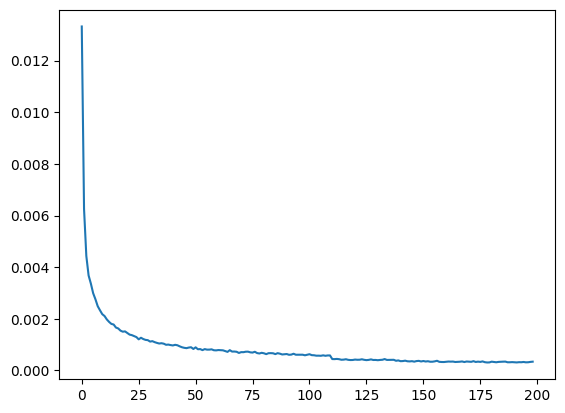

In [37]:
plt.plot(loss_epoch)

Training went smoothly, the step after 100 epochs accured due to learning rate change 

Lets evaluate the performance of our model on the test set

In [43]:
def evaluation_of_net(net, test_loader, class_number, interpolate=False, norm_grid = False ):
    net.eval()
    labels = []
    predictions = []
    misclassified_samples = []
    misclassified_count = 0
    probas = []

    for inputs, label in test_loader:
        if interpolate:
            inputs = interpolate(inputs, size=(16, 16), mode='bilinear')
        inputs = inputs.to(device)
        label = label.to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs, 1)

        # Aggregate outputs for PR-AUC calculation
        probas.extend(outputs.cpu().detach().numpy())

        # Extend labels and predictions for the entire batch
        labels.extend(label.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

        # Batch processing for misclassified samples
        misclassified_indices = np.where(predicted.cpu().numpy() != label.cpu().numpy())[0]
        misclassified_count += len(misclassified_indices)
        for index in misclassified_indices:
            misclassified_samples.append((label[index].item(), predicted[index].item(), inputs[index].cpu().numpy()))

    correctly_classified = (len(labels) - misclassified_count) * 100 / len(labels)
    print(f'- accuracy: {correctly_classified:.2f} %')
    print(f'- misclassification: {100 - correctly_classified:.2f} %')

    # Confusion Matrix and Class-specific Accuracies
    cm = confusion_matrix(labels, predictions)
    if class_number == 2:
        TN, FP, FN, TP = cm.ravel()
        # Calculate sensitivity and specificity
        sensitivity = TP / (TP + FN)
        specificity = TN / (TN + FP)
    
        # Calculate Balanced Accuracy
        balanced_accuracy = (sensitivity + specificity) / 2
        print(f'- Balanced Accuracy: {balanced_accuracy * 100:.2f} %')
        # F1 Score Calculation
        f1 = f1_score(labels, predictions)
        print(f'- F1 Score: {f1:.2f}')
    
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    average_class_accuracy = class_accuracies.sum()/ class_accuracies.shape[0]
    print(f'- average class accuracy: {average_class_accuracy * 100:.5f} %')
    for i, acc in enumerate(class_accuracies):
        print(f"Class {i} Accuracy: {acc:.2f}")

    # PR-AUC Calculation
    y_real = label_binarize(labels, classes=[i for i in range(class_number)])
    y_proba = np.array(probas)

    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(class_number):
        precision[i], recall[i], _ = precision_recall_curve(y_real[:, i], y_proba[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    # Averaging PR-AUC scores across classes
    average_pr_auc = np.mean(list(pr_auc.values()))
    print(f'- average PR-AUC: {average_pr_auc}')

    fig, ax = plt.subplots(figsize=(12, 8))
    plt.rcParams.update({'font.size': 16})
    mpl.rc('image', cmap='cividis')
    cmp = ConfusionMatrixDisplay(cm, display_labels=[i for i in range(class_number)])
    cmp.plot(ax=ax)
    plt.show()

    return correctly_classified, average_class_accuracy , pr_auc, labels, predictions, misclassified_samples

- accuracy: 95.35 %
- misclassification: 4.65 %
- average class accuracy: 90.32975 %
Class 0 Accuracy: 0.98
Class 1 Accuracy: 0.95
Class 2 Accuracy: 0.88
Class 3 Accuracy: 0.80
- average PR-AUC: 0.915739821977966


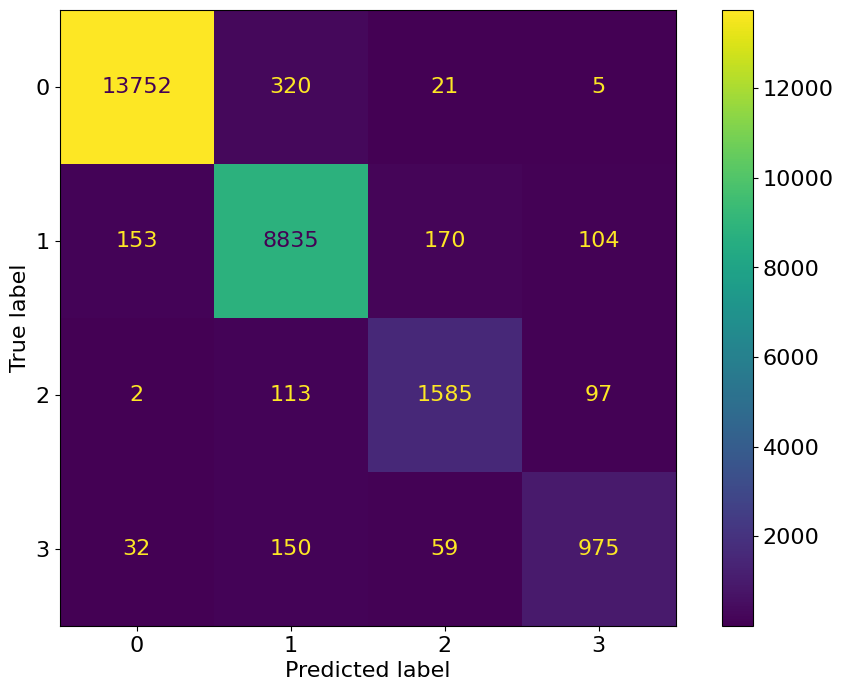

In [44]:
correctly_classified, average_class_accuracy, pr_auc, labels, predictions, misclassified_samples = evaluation_of_net(model, test_loader, class_number)

## 2. Multiple people Localization

In [46]:
path_test = "D:\IR_blobs\IR_blobs_github\data_IR_final\localization\localization_test_12_06_final.csv"
path_train = "D:\IR_blobs\IR_blobs_github\data_IR_final\localization\localization_train_12_06_final.csv"

In [47]:
df_test = pd.read_csv(path_test)
df_train = pd.read_csv(path_train)

In [48]:
pd.set_option('display.max_columns', None)

In [55]:
df_train.tail() 

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,Pixel 11,Pixel 12,Pixel 13,Pixel 14,Pixel 15,Pixel 16,Pixel 17,Pixel 18,Pixel 19,Pixel 20,Pixel 21,Pixel 22,Pixel 23,Pixel 24,Pixel 25,Pixel 26,Pixel 27,Pixel 28,Pixel 29,Pixel 30,Pixel 31,Pixel 32,Pixel 33,Pixel 34,Pixel 35,Pixel 36,Pixel 37,Pixel 38,Pixel 39,Pixel 40,Pixel 41,Pixel 42,Pixel 43,Pixel 44,Pixel 45,Pixel 46,Pixel 47,Pixel 48,Pixel 49,Pixel 50,Pixel 51,Pixel 52,Pixel 53,Pixel 54,Pixel 55,Pixel 56,Pixel 57,Pixel 58,Pixel 59,Pixel 60,Pixel 61,Pixel 62,Pixel 63,Pixel 64,session,target_coordinates,people_#
42710,20.78,18.93,17.46,17.17,17.64,18.14,17.57,18.54,20.10,19.27,17.82,17.34,17.68,17.84,19.82,21.44,17.43,17.38,17.40,17.45,17.52,18.22,19.74,20.23,16.86,16.93,17.34,17.59,17.50,17.55,17.67,17.94,16.73,17.04,17.24,17.10,17.21,17.50,17.13,17.45,17.04,17.83,17.33,16.96,16.98,17.67,16.99,16.91,19.21,18.93,17.40,16.43,17.03,16.87,16.43,16.32,19.66,17.30,16.33,16.46,16.27,16.57,16.72,15.40,268,"[(0, 0), (7, 1), (0, 7)]",3
42711,20.64,18.66,17.45,17.32,17.77,18.04,18.63,19.92,20.15,19.11,17.77,17.49,17.42,17.65,19.83,20.97,17.17,17.43,17.19,16.97,17.48,17.95,18.80,18.30,16.90,16.91,17.17,17.42,17.27,17.52,17.51,17.70,16.83,16.94,17.15,16.98,17.16,17.20,16.88,17.53,17.15,17.89,17.23,17.00,17.16,17.82,17.16,16.77,18.98,18.77,17.37,16.31,17.24,17.01,16.59,16.09,19.29,17.49,16.10,16.22,16.09,16.44,16.17,15.99,268,"[(0, 0), (7, 1), (0, 7)]",3
42712,20.97,18.72,17.37,17.44,17.66,18.24,19.46,20.88,20.13,19.00,17.59,17.46,17.61,17.92,19.90,20.69,17.02,16.96,17.30,17.16,17.51,18.06,17.55,17.57,16.77,16.90,17.17,17.19,17.23,17.40,17.68,17.42,16.80,16.92,17.17,16.97,17.25,17.41,16.91,17.27,16.81,17.96,17.19,16.93,17.14,17.61,16.94,16.59,18.97,18.39,17.17,16.29,16.89,16.99,16.34,15.70,19.20,17.39,16.16,16.21,15.89,16.57,16.23,15.68,268,"[(0, 0), (7, 0), (0, 7)]",3
42713,20.86,18.82,17.34,17.39,17.59,18.15,19.67,20.80,20.04,19.04,17.68,17.52,17.68,18.32,20.09,20.86,17.20,17.29,17.66,17.52,17.71,18.00,17.48,18.31,17.14,17.06,17.23,17.25,17.64,17.48,17.43,18.02,16.46,17.06,17.27,17.24,17.35,17.62,16.94,17.27,17.09,17.92,17.51,16.95,17.02,17.86,17.19,16.88,18.94,18.55,17.13,16.43,17.09,16.89,16.87,16.52,19.27,17.38,16.00,16.41,15.77,16.51,15.78,15.80,268,"[(0, 0), (7, 1), (0, 7)]",3
42714,20.98,18.98,17.47,17.55,17.65,18.11,19.89,20.99,20.08,19.09,17.95,17.64,17.75,17.78,20.09,20.36,17.31,17.19,17.48,17.19,17.54,17.90,17.75,18.10,16.99,17.04,17.32,17.17,17.20,17.24,17.81,17.52,16.71,17.14,17.29,17.27,17.28,17.42,16.98,17.71,16.80,17.54,17.56,16.91,17.23,17.65,17.22,16.67,18.86,19.12,17.79,16.61,17.12,16.87,16.45,16.29,19.73,18.22,16.39,16.51,16.25,16.54,16.12,15.61,268,"[(0, 0), (7, 0), (0, 7)]",3


In [54]:
df_train.describe() 

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,Pixel 11,Pixel 12,Pixel 13,Pixel 14,Pixel 15,Pixel 16,Pixel 17,Pixel 18,Pixel 19,Pixel 20,Pixel 21,Pixel 22,Pixel 23,Pixel 24,Pixel 25,Pixel 26,Pixel 27,Pixel 28,Pixel 29,Pixel 30,Pixel 31,Pixel 32,Pixel 33,Pixel 34,Pixel 35,Pixel 36,Pixel 37,Pixel 38,Pixel 39,Pixel 40,Pixel 41,Pixel 42,Pixel 43,Pixel 44,Pixel 45,Pixel 46,Pixel 47,Pixel 48,Pixel 49,Pixel 50,Pixel 51,Pixel 52,Pixel 53,Pixel 54,Pixel 55,Pixel 56,Pixel 57,Pixel 58,Pixel 59,Pixel 60,Pixel 61,Pixel 62,Pixel 63,Pixel 64,session,people_#
count,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.00000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.00000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000,42715.000000
mean,16.845126,16.898928,16.965858,16.986448,17.153517,17.446585,17.026555,16.893169,16.714208,16.719344,17.040512,17.030901,17.230637,17.227105,17.057059,17.012497,16.770933,16.746901,16.901666,16.899997,16.986785,17.45893,16.915009,17.152332,16.770055,16.651906,16.801741,16.943964,16.999932,17.019572,17.254725,17.013607,16.527193,16.655184,16.818231,16.850912,17.058185,17.061847,16.799116,16.939650,16.665056,16.739507,16.656212,16.727167,16.832454,17.355020,17.088716,16.357971,16.072622,16.279093,16.705724,16.337583,16.969345,16.809721,16.600954,15.995530,15.816963,15.79334,15.812303,16.074885,15.932682,16.405943,16.183402,15.298757,130.024980,2.216130
std,1.215600,1.149243,1.130387,1.221679,1.195400,1.364527,1.464996,1.380490,1.309463,1.221094,1.115030,1.045392,1.017713,1.121288,1.227332,1.257311,1.202482,0.994535,1.017881,0.889819,0.946620,0.97162,1.064509,1.145809,1.133319,0.965033,0.942735,0.976712,0.944356,0.926091,1.189607,1.240218,1.142780,0.927693,0.982977,0.934599,0.905964,0.897566,1.051827,1.159494,1.120777,1.057776,0.929318,0.924799,0.900570,1.038722,1.102789,1.056512,1.295540,1.112387,1.029952,1.040687,1.011910,1.070460,1.264246,1.031206,1.277267,1.02758,1.002278,1.171418,1.035883,0.975930,1.127857,0.912303,78.536814,0.848178
min,12.910000,12.490000,12.790000,13.230000,12.960000,12.510000,12.600000,12.020000,13.050000,13.080000,12.410000,13.500000,13.820000,13.700000,13.330000,12.110000,12.920000,13.050000,12.480000,13.430000,13.430000,13.98000,13.190000,13.090000,13.590000,13.230000,13.300000,13.400000,13.270000,13.350000,13.440000,13.020000,12.090000,13.180000,13.520000,13.030000,13.300000,13.290000,13.280000,12.860000,12.990000,13.270000,13.220000,13.190000,13.360000,13.830000,13.390000,12.520000,12.360000,12.520000,13.020000,12.670000,13.390000,13.000000,12.860000,12.040000,12.120000,12.24000,12.180000,12.560000,12.210000,12.980000,12.730000,12.010000,0.000000,0.000000
25%,16.200000,16.280000,16.340000,16.340000,16.610000,16.900000,16.290000,16.320000,15.970000,16.010000,16.410000,16.440000,16.650000,16.570000,16.340000,16.440000,16.150000,16.180000,16.320000,16.370000,16.450000,16.92000,16.320000,16.540000,16.140000,16.100000,16.260000,16.365000,16.450000,16.510000,16.610000,16.340000,15.860000,16.110000,16.240000,16.290000,16.530000,16.560000,16.200000,16.290000,15.980000,16.080000,16.120000,16.180000,16.320000,16.750000,16.440000,15.770000,15.220000,15.580000,16.100000,15.760000,16.390000,16.160000,15.820000,15.400000,14.950000,15.17000,15.250000,15.440000,15.380000,15.860000,15.540000,1

In [56]:
df_test.describe() 

,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,Pixel 10,Pixel 11,Pixel 12,Pixel 13,Pixel 14,Pixel 15,Pixel 16,Pixel 17,Pixel 18,Pixel 19,Pixel 20,Pixel 21,Pixel 22,Pixel 23,Pixel 24,Pixel 25,Pixel 26,Pixel 27,Pixel 28,Pixel 29,Pixel 30,Pixel 31,Pixel 32,Pixel 33,Pixel 34,Pixel 35,Pixel 36,Pixel 37,Pixel 38,Pixel 39,Pixel 40,Pixel 41,Pixel 42,Pixel 43,Pixel 44,Pixel 45,Pixel 46,Pixel 47,Pixel 48,Pixel 49,Pixel 50,Pixel 51,Pixel 52,Pixel 53,Pixel 54,Pixel 55,Pixel 56,Pixel 57,Pixel 58,Pixel 59,Pixel 60,Pixel 61,Pixel 62,Pixel 63,Pixel 64,session,people_#
count,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.000000,11050.00000,11050.000000,11050.000000,11050.000000
mean,16.874330,16.921444,16.976503,16.971698,17.174776,17.478671,17.050977,16.974066,16.724832,16.744799,17.087674,17.029565,17.267544,17.237629,17.058465,17.078401,16.856981,16.809812,16.988185,16.950543,17.074374,17.511714,16.918392,17.176538,16.783467,16.717047,16.871586,16.997138,17.056458,17.038457,17.265719,17.017191,16.503244,16.684624,16.907675,16.880801,17.106652,17.080072,16.799324,16.953208,16.664822,16.781742,16.718013,16.769567,16.891094,17.410037,17.104938,16.376304,15.974565,16.247051,16.725203,16.317422,16.991969,16.814239,16.521136,15.963922,15.769124,15.784101,15.815153,16.077814,15.937851,16.414398,16.10871,15.265738,37.976561,1.949231
std,1.033223,1.023157,1.045179,1.050542,1.071565,1.231595,1.346729,1.261470,1.282029,1.163880,1.058479,0.949195,0.984129,1.082941,1.181676,1.155345,1.203697,0.998438,0.960331,0.875535,0.949656,0.961478,1.012309,1.034940,1.065849,0.949678,0.926547,0.931826,0.920005,0.893848,1.070146,1.059314,0.996061,0.905424,0.986412,0.913349,0.909681,0.894319,1.022788,1.036986,1.031338,0.998744,0.927739,0.891337,0.904230,1.012676,1.089616,1.015642,1.132799,1.035803,0.969334,0.967350,0.969329,1.090223,1.175530,0.923270,1.129771,0.953245,0.974218,1.019293,0.961399,0.965692,1.01426,0.816669,22.348382,0.975142
min,13.400000,13.490000,13.380000,13.420000,13.120000,13.090000,12.810000,12.220000,13.260000,13.230000,13.140000,13.320000,13.760000,13.680000,13.210000,12.520000,12.730000,13.120000,13.230000,13.100000,13.350000,13.910000,13.160000,13.390000,13.320000,12.950000,13.130000,13.240000,13.330000,13.300000,13.730000,13.080000,13.130000,13.200000,13.020000,13.290000,13.500000,13.450000,13.110000,13.360000,13.010000,13.270000,13.080000,12.970000,13.160000,13.850000,13.610000,12.240000,12.460000,12.760000,13.130000,12.570000,13.350000,13.100000,12.760000,12.160000,12.100000,12.290000,12.260000,12.170000,12.170000,12.860000,12.54000,12.020000,0.000000,0.000000
25%,16.360000,16.400000,16.420000,16.460000,16.730000,17.020000,16.410000,16.510000,16.020000,16.100000,16.540000,16.520000,16.750000,16.650000,16.410000,16.640000,16.262500,16.230000,16.490000,16.450000,16.590000,17.000000,16.370000,16.690000,16.200000,16.180000,16.350000,16.480000,16.540000,16.550000,16.750000,16.510000,15.950000,16.170000,16.390000,16.370000,16.600000,16.580000,16.220000,16.400000,16.070000,16.230000,16.220000,16.270000,16.380000,16.850000,16.460000,15.810000,15.260000,15.640000,16.170000,15.800000,16.432500,16.160000,15.820000,15.430000,15.040000,15.240000,15.310000,15.540000,15.440000,15.880000,15.550

In [ ]:
def format_data_localization(df):

    pixel = df.columns[0:64]
    sessions = np.unique(df["session"])
    # Assuming 'df' is a pandas DataFrame
    sessions_unique = df['session'].unique()
    num_sessions = len(sessions_unique)

    # Preallocate a list of NumPy arrays with known dimensions
    session_arrays = [None] * num_sessions
    
    for i, session_label in enumerate(sessions_unique):
        df_temp = df[df['session'] == session_label]
        # Preallocate object array for tuples (image, empty array) for each image
        pics_tuples = np.empty((len(df_temp),), dtype=object)

        for idx, row in df_temp.iterrows():
            # Extract pixel values and check if it can be reshaped to 8x8
            pic = pd.to_numeric(row[pixel], errors='coerce').values
            min_value = pic.min()
            if pic.size == 64:
                pic_reshaped = pic.reshape((8, 8))
                empty_8x8 = np.zeros((8, 8))  # Create an empty 8x8 array

                targets = ast.literal_eval(row["target_coordinates"])

                for p in targets:

                    #a = p[0]
                    #b = p[1]
                    a = p[1]
                    b = p[0]

                    empty_8x8[a][b] = 1
                pic_reshaped = pic_reshaped - min_value
                pics_tuples[idx - df_temp.index[0]] = (pic_reshaped.reshape(1, 8, 8), empty_8x8)
            else:
                raise ValueError("The image does not have exactly 64 pixels to reshape into 8x8")

        session_arrays[i] = pics_tuples 
        
    return session_arrays


def prepare_data_localization(df, sequence=True, seq_len=8):
    data = format_data_localization(df)
    data_collection = []

    if sequence:
        for seq in data:
            num_frames = len(seq)
            for i in range(num_frames - seq_len + 1):
                frames = np.concatenate([seq[j][0] for j in range(i, i + seq_len)])
                detection_map = seq[i + seq_len - 1][1]
                frames_expanded = np.expand_dims(frames, axis=1)
                data_collection.append((frames_expanded, detection_map))
    else:
        for seq in data:
            data_collection.extend(seq)
    
    return data_collection

In [57]:
def format_data_localization(df):

    pixel = df.columns[0:64]
    sessions = np.unique(df["session"])
    # Assuming 'df' is a pandas DataFrame
    sessions_unique = df['session'].unique()
    num_sessions = len(sessions_unique)

    # Preallocate a list of NumPy arrays with known dimensions
    session_arrays = [None] * num_sessions
    
    for i, session_label in enumerate(sessions_unique):
        df_temp = df[df['session'] == session_label]
        # Preallocate object array for tuples (image, empty array) for each image
        pics_tuples = np.empty((len(df_temp),), dtype=object)

        for idx, row in df_temp.iterrows():
            # Extract pixel values and check if it can be reshaped to 8x8
            pic = pd.to_numeric(row[pixel], errors='coerce').values
            min_value = pic.min()
            if pic.size == 64:
                pic_reshaped = pic.reshape((8, 8))
                empty_8x8 = np.zeros((8, 8))  # Create an empty 8x8 array

                targets = ast.literal_eval(row["target_coordinates"])

                for p in targets:

                    #a = p[0]
                    #b = p[1]
                    a = p[1]
                    b = p[0]

                    empty_8x8[a][b] = 1
                pic_reshaped = pic_reshaped - min_value
                pics_tuples[idx - df_temp.index[0]] = (pic_reshaped.reshape(1, 8, 8), empty_8x8)
            else:
                raise ValueError("The image does not have exactly 64 pixels to reshape into 8x8")

        session_arrays[i] = pics_tuples 
        
    return session_arrays


def prepare_data_localization(df, sequence=True, seq_len=8):
    data = format_data_localization(df)
    data_collection = []

    if sequence:
        for seq in data:
            num_frames = len(seq)
            for i in range(num_frames - seq_len + 1):
                frames = np.concatenate([seq[j][0] for j in range(i, i + seq_len)])
                detection_map = seq[i + seq_len - 1][1]
                frames_expanded = np.expand_dims(frames, axis=1)
                data_collection.append((frames_expanded, detection_map))
    else:
        for seq in data:
            data_collection.extend(seq)
    
    return data_collection

In [58]:
#set the sequence length to the optimal 8 subsequent frames in order to capture temporal changes leading to the current frame
seq_len = 8
collection_train_seq = prepare_data_localization(df_train, sequence=True, seq_len=seq_len)
collection_test_seq = prepare_data_localization(df_test, sequence=True, seq_len=seq_len)

In [59]:
#preparing Torch datasets
class SimpleTorchDataset(Dataset):
    def __init__(self, data_collection):
        self.data_collection = data_collection

    def __len__(self):
        return len(self.data_collection)

    def __getitem__(self, idx):
        frames, label = self.data_collection[idx]
        
        # Ensure frames and label are numpy arrays of appropriate types
        frames = np.array(frames, dtype=np.float32)
        label = np.array(label, dtype=np.float32)
        
        # Convert to PyTorch tensors
        frames = torch.tensor(frames, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.float32)
        
        return frames, label


def create_datasets(data_collection_train, data_collection_test):
    # Creating PyTorch datasets
    train_set = SimpleTorchDataset(data_collection_train)
    test_set = SimpleTorchDataset(data_collection_test)
    
    return train_set, test_set

In [60]:
train_set, test_set = create_datasets(collection_train_seq, collection_test_seq)

In [62]:
batch_size = 64
num_epochs = 500
interpolate = False
dim_dim = [8, 16]
std = 0.008
patience = 20
learning_rate = 0.0007
date = 120624
code_word = f"clstm_unet_8_16_len{seq_len}_shrink_std{std}_lr{learning_rate}_pt{patience}_{date}"

In [63]:
train_loader = dataset_to_loader(train_set, batch_size, balancing = False, shuffle = True)
test_loader = dataset_to_loader(test_set, batch_size, balancing = False, shuffle = False)

In [67]:
#Convolutional LSTM version of UNET with temporal and spatial awareness 
#The implementation of the ConvLSTM Cell is taken from from https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=True, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor):
        """

        Parameters
        ----------
        input_tensor: 
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        
        # Since the init is done in forward. Can send image size here
        hidden_state = self._init_hidden(batch_size=b,
                                         image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

#Adaptation of DoubleCNN class:
class DoubleConvLSTM(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim, kernel_size=(3,3), bias=True):
        super(DoubleConvLSTM, self).__init__()
        self.conv_lstm = ConvLSTM(input_dim=in_channels,
                                  hidden_dim=[hidden_dim, hidden_dim],
                                  kernel_size=kernel_size,
                                  num_layers=2,
                                  batch_first=True,
                                  bias=bias,
                                  return_all_layers=False)
    def forward(self, x):
        # Assuming x is of shape (batch, seq_len, channels, height, width)
        #print(f'in double conv: {x.shape}')
        layer_output_list, _ = self.conv_lstm(x)
        # Take the output of the last layer
        x = layer_output_list[-1]  # Shape: (batch, seq_len, channels, height, width)
        # We take the output of the last timestep
        #x = x[:, -1, :, :, :]  # Shape: (batch, channels, height, width)
        #print(f'in double conv after first LSTM: {x.shape}')
        return x



#The LSTM where pooling is performed oly before the bottleneck
class T_UNET_IR(nn.Module):
    def __init__(
            self, in_channels=1, out_channels=1, features=[16, 32], hidden_dims=[16, 32], incl_botneck = False
    ):
        super(T_UNET_IR, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.incl_botneck = incl_botneck

        # Down part of UNET
        for i, feature in enumerate(features):
            self.downs.append(DoubleConvLSTM(in_channels, feature, hidden_dim=hidden_dims[i]))
            in_channels = feature
        
        # Up part of UNET
        for i, feature in enumerate(reversed(features)):
            if i == 0:
                self.ups.append(
                    nn.ConvTranspose2d(
                        feature*2, feature, kernel_size=2, stride=2,
                    )
                )
                self.ups.append(DoubleConv(feature*2, feature))
            else:
                self.ups.append(DoubleConv(feature*3, feature))      
        if self.incl_botneck:
            self.bottleneck = DoubleConvLSTM(features[-1], features[-1]*2, hidden_dim=hidden_dims[-1]*2)
        else:
            self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x[:, -1, :, :, :])
        if self.incl_botneck == False:
            x = x[:, -1, :, :, :]
        x = self.pool(x)
        #print(f'before bottle neck: {x.shape}')
        x = self.bottleneck(x)
        if self.incl_botneck:
            x = x[:, -1, :, :, :]
        skip_connections = skip_connections[::-1]
        #print(f'after bottle neck: {x.shape}')
        x = self.ups[0](x)
        skip_connection = skip_connections[0]
        if x.shape != skip_connection.shape:
            x = TF.resize(x, size=skip_connection.shape[2:])
        concat_skip = torch.cat((skip_connection, x), dim=1)
        x = self.ups[1](concat_skip)
        start = 2

        for idx in range(start, len(self.ups)):
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx](concat_skip)
            #print(f'upbranch: {x.shape}, skip connection{skip_connection.shape}')


        return self.final_conv(x)

In [68]:
model = T_UNET_IR(features=dim_dim, hidden_dims=dim_dim, incl_botneck = False)
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

T_UNET_IR(
  (ups): ModuleList(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (2): DoubleConv(
      (conv): Sequential(
        (0): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affi

In [69]:
#Focal loss to account for class imbalance (head location vs pixel without head) withing the frame
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

Specifying the loss function and optizer to use in the training

In [70]:
criterion = FocalLoss(alpha = 0.8, gamma = 4.0, reduction = 'sum').to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [72]:
#Data augmentations:
def RandomHorizontalFlip(sample, prob, dim = 2):
    number = random.random()
    state = False
    if number <= prob:
        state = True
        return torch.flip(sample, (dim,)), state
    else:
        return sample, state

def RandomVerticalFlip(sample, prob, dim = 3):
    number = random.random()
    state = False
    if number <= prob:
        state = True
        return torch.flip(sample, (dim,)), state
    else:
        return sample, state

def AddValue(frame):
    tensor_ones = torch.ones(frame.shape)
    integer_ = random.randint(0, 2)
    float_ = random.random()
    return frame + tensor_ones.to(device)*(integer_ + float_)

class AddGaussianNoise:
    def __init__(self, mean=0., std=0.5):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()).to(device) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)



def apply_augmentation(inputs, add_noise = True, dim = (2, 3), add_val = False, std = 0.05):
    noise = AddGaussianNoise(mean=0., std=std)
    inputs, state_hor = RandomHorizontalFlip(inputs, 0.5, dim[0])
    inputs, state_ver = RandomVerticalFlip(inputs, 0.5, dim[1])
    if add_noise:
        inputs = noise(inputs)
    if add_val:
        inputs = AddValue(inputs)
    return inputs, (state_hor, state_ver)

#we need to flip labels for localization task only
def flip_labels(labels, states):
    state_hor, state_ver = states
    if state_hor:
        labels = torch.flip(labels, (1,))
    if state_ver:
        labels = torch.flip(labels, (2,))
    return labels



def network_training_detect(net, train_loader, criterion, optimizer, num_epochs, code_word, path_to_save, interpolate = True, sequence = False, add_noise = False, patience = 20, std = 0.02, factor = 0.3):
    patience_counter = 0  # Early stopping counter
    epoch_recall_max = 0
    start_time = time.time()
    learning_rate_list = []
    loss_batch = []
    loss_epoch = []
    if sequence:
        dim_aug = (3, 4)
    else:
        dim_aug = (2, 3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=patience//2, factor = factor)
    current_lr = optimizer.param_groups[0]['lr']
    print(f'current learning rate:{current_lr}')
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_loss_epoch = 0.0
        running_corrects = 0
        running_true_positives = 0
        running_false_negatives = 0
        running_true_negatives = 0
        running_false_positives = 0
        total_pixels = 0  # total number of pixels processed
        net.train()
        current_lr = optimizer.param_groups[0]['lr']
        learning_rate_list.append(current_lr)
        if patience_counter >= patience//2:
            print(f'current learning rate:{current_lr}')  
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, states = apply_augmentation(inputs.to(device), add_noise = add_noise, dim = dim_aug, std = std)
            if interpolate == True:
                inputs = F.interpolate(inputs, size=(16, 16), mode='bilinear')
            inputs = inputs.to(device)
            #to flip the target mask as well as input:
            labels = flip_labels(labels, states)
            #print(f'labels after flipping {labels[0]}')
            labels = labels.float().to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = net(inputs)
                loss = criterion(outputs.squeeze(1), labels)
                loss.backward()
                optimizer.step()

            # calculate running loss & accuracy
            running_loss += loss.item()
            running_loss_epoch += loss.item()

            preds = (outputs > 0.5).squeeze(1)  # threshold predictions
            running_corrects += torch.sum(preds == labels.bool())
            running_true_positives += torch.sum((preds == 1) & (labels.bool() == 1))
            running_false_negatives += torch.sum((preds == 0) & (labels.bool() == 1))
            running_true_negatives += torch.sum((preds == 0) & (labels.bool() == 0))
            running_false_positives += torch.sum((preds == 1) & (labels.bool() == 0))
            total_pixels += labels.numel()

            if i % 200 == 199:  # print every 200 mini-batches
                loss_batch.append(running_loss / 200)
                running_loss = 0.0
        epoch_recall = running_true_positives / (running_true_positives + running_false_negatives)
        epoch_acc = (running_true_positives + running_true_negatives) / (running_true_positives + running_true_negatives + running_false_positives + running_false_negatives)
        scheduler.step(epoch_recall)
        loss_epoch.append(running_loss_epoch / len(train_loader.dataset))
        print(f'EPOCH {epoch}: Accuracy: {epoch_acc:.4f}')
        print(f'Recall: {epoch_recall} ')
        print(f'tp: {running_true_positives}, fn: {running_false_negatives}, fp: {running_false_positives}, tn: {running_true_negatives}')
        print(f'Epoch loss: {running_loss_epoch / len(train_loader.dataset)}')
        running_loss_epoch = 0.0
        if epoch_recall > epoch_recall_max:
            epoch_recall_max = epoch_recall
            torch.save(net.state_dict(), f'{path_to_save}/model_{code_word}.pt')
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch}.')
            break  # Stop training if patience limit is reached

    training_time = time.time() - start_time
    print(f'Time of training: {training_time:.2f} seconds')
    print(f'Max recall: {epoch_recall_max:.4f}')
    return net, loss_batch, loss_epoch, learning_rate_list

Next we run training of our model. On each epoch the 

In [73]:
model, loss_batch, loss_epoch, learniung_rate_list = network_training_detect(model, train_loader, criterion, optimizer, num_epochs, code_word, path_to_save, interpolate = False, sequence = True, add_noise = True, patience = patience, std = std)

current learning rate:0.0007
EPOCH 0: Accuracy: 0.9723
Recall: 0.2034350037574768 
tp: 18395, fn: 72027, fp: 419, tn: 2522407
Epoch loss: 0.36950541651431107
EPOCH 1: Accuracy: 0.9918
Recall: 0.7722235918045044 
tp: 69826, fn: 20596, fp: 772, tn: 2522054
Epoch loss: 0.04835031996408133
EPOCH 2: Accuracy: 0.9936
Recall: 0.820840060710907 
tp: 74222, fn: 16200, fp: 640, tn: 2522186
Epoch loss: 0.03839988737924719
EPOCH 3: Accuracy: 0.9943
Recall: 0.8425272703170776 
tp: 76183, fn: 14239, fp: 582, tn: 2522244
Epoch loss: 0.03445296826389936
EPOCH 4: Accuracy: 0.9948
Recall: 0.8554112911224365 
tp: 77348, fn: 13074, fp: 571, tn: 2522255
Epoch loss: 0.03198243164074925
EPOCH 5: Accuracy: 0.9953
Recall: 0.8689699172973633 
tp: 78574, fn: 11848, fp: 468, tn: 2522358
Epoch loss: 0.029196791298290406
EPOCH 6: Accuracy: 0.9955
Recall: 0.8759593963623047 
tp: 79206, fn: 11216, fp: 477, tn: 2522349
Epoch loss: 0.02792395760967954
EPOCH 7: Accuracy: 0.9957
Recall: 0.8798522353172302 
tp: 79558, fn:

Evaluation of the model

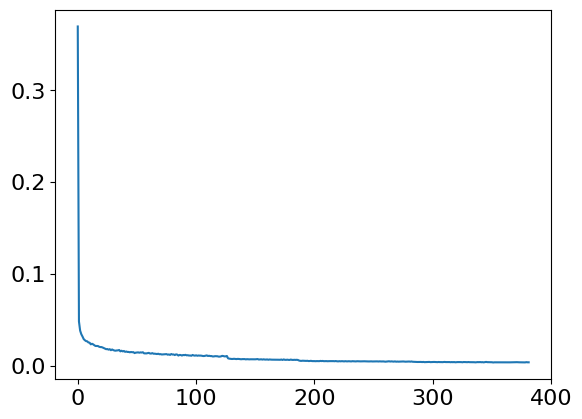

In [76]:
plt.plot(loss_epoch)

We can see that training went smoothly with training loss decreasing close to 0 assymptotycally

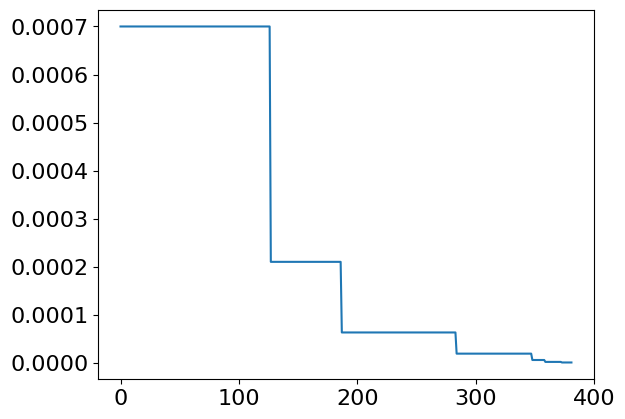

In [79]:
plt.plot(learniung_rate_list)

Here you can see how learning rate scheduler changed the learning rate several times which caused corresponding speedups that we see on the loss function plot

In [87]:
def is_correctly_classified(pred, label, original_input, temp_threshold, slack):
    """
    Check if the predicted peaks are correctly classified based on temperature difference
    and spatial proximity, ensuring unique matches.
    """
    count_targets = (label == 1).sum().item()  # Count of target peaks
    count_detections = (pred == 1).sum().item()  # Count of detected peaks
    #if (count_targets + 1 < count_detections) or (count_targets > count_detections):
    #    return False, False  # Early return if the counts don't match

    # Initialize a mask to track matched predictions
    matched_preds = torch.zeros_like(pred, dtype=torch.bool)
    
    # This will store the minimum distance match for each target
    best_match = {}

    for i in range(label.shape[0]):  
        for j in range(label.shape[1]):
            if label[i, j] == 1:  # Target peak
                min_distance = float('inf')
                best_idx = None
                min_i, max_i = max(0, i-slack), min(label.shape[0], i+slack+1)
                min_j, max_j = max(0, j-slack), min(label.shape[1], j+slack+1)
                
                for mi in range(min_i, max_i):
                    for mj in range(min_j, max_j):
                        if pred[mi, mj] == 1 and not matched_preds[mi, mj]:
                            #distance to choose the closest prediction only
                            distance = (mi - i)**2 + (mj - j)**2
                            temp_diff = abs(original_input[mi, mj] - original_input[i, j])
                            if temp_diff <= temp_threshold and distance < min_distance:
                                min_distance = distance
                                best_idx = (mi, mj)
                
                if best_idx:
                    matched_preds[best_idx[0], best_idx[1]] = True
                    best_match[(i, j)] = best_idx

    # Check if all targets have been matched uniquely
    targets_detected = len(best_match)
    correctly_classified = (targets_detected == count_targets and count_targets == count_detections)
    return correctly_classified



def evaluation_of_detection_joint(net, test_loader, device, margin_of_error=0, interpolate=False, temp_threshold=0.5, sequence = False, slack = 1):
    net.eval()

    # Initialize metrics
    total_pixels = 0
    correct_pixels = 0
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    image_level_correct_relaxed = 0
    image_level_correct = 0
    misclassified_samples = []
    labels = []
    mis_idxs = []
    tolerables = 0
    tolearable = False

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            if sequence:
                original_inputs = inputs[:,-1,:,:,:].clone().squeeze(1)
            else:
                original_inputs = inputs.clone().squeeze(1)
            if interpolate:
                inputs = F.interpolate(inputs, size=(16, 16), mode='bilinear')

            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            outputs = torch.sigmoid(outputs).squeeze(1)

            # Threshold outputs to get binary predictions
            preds = (outputs > 0.5).to(device)#1,8,8

            for idx in range(preds.size(0)):  # Loop through batch
                pred = preds[idx]  #8,8
                label = labels[idx] #8,8
                original_input = original_inputs[idx].to(device) #8,8

                # Image-level accuracy with margin of error
                diff = torch.abs(pred.float() - label.float())
                if torch.all(diff <= margin_of_error):
                    image_level_correct += 1

                # Image-level accuracy with slack, allowing the predicted location be a little bit different than target one
                correctly_classified = is_correctly_classified(pred, label, original_input, temp_threshold, slack)
                if correctly_classified:
                    image_level_correct_relaxed += 1
                else:
                    misclassified_samples.append((i, original_input.cpu(), pred.cpu(), label.cpu()))
            # Update pixel-level metrics
            correct_pixels += torch.sum(preds == labels).item()
            total_pixels += labels.numel()

            # Update true positives, false positives, and false negatives
            true_positives += torch.sum((preds == 1) & (labels == 1)).item()
            false_positives += torch.sum((preds == 1) & (labels == 0)).item()
            false_negatives += torch.sum((preds == 0) & (labels == 1)).item()

    pixel_accuracy = correct_pixels / total_pixels
    pixel_recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives else 0
    pixel_precision = true_positives / (true_positives + false_positives) if true_positives + false_positives else 0
    image_level_accuracy = image_level_correct / len(test_loader.dataset)
    image_level_accuracy_relaxed = image_level_correct_relaxed / len(test_loader.dataset)
    
    print(f"Pixel-Level Accuracy: {pixel_accuracy}")
    print(f"Pixel-Level Recall: {pixel_recall}")
    print(f"Pixel-Level Precision: {pixel_precision}")
    print(f"Image-Level Accuracy: {image_level_accuracy}")
    print(f"Image-Level Accuracy Relaxed: {image_level_accuracy_relaxed}")

    return {
        'pixel_accuracy': pixel_accuracy,
        'pixel_recall': pixel_recall,
        'pixel_precision': pixel_precision,
        'image_level_accuracy': image_level_accuracy,
        'image_level_accuracy_relaxed': image_level_accuracy_relaxed,
        'misclassified_samples': misclassified_samples
    }


In [88]:
results_dict = evaluation_of_detection_joint(model, test_loader, device, margin_of_error=0, interpolate=False, temp_threshold=0.5, sequence = True, slack = 1)

Pixel-Level Accuracy: 0.9988999619446295
Pixel-Level Recall: 0.9795500024403339
Pixel-Level Precision: 0.9842577607768133
Image-Level Accuracy: 0.95100371039863
Image-Level Accuracy Relaxed: 0.9669869660355818
